In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.14.0


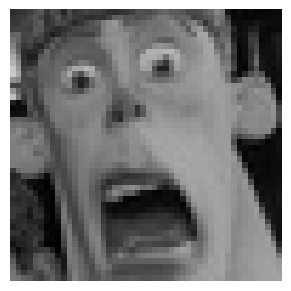

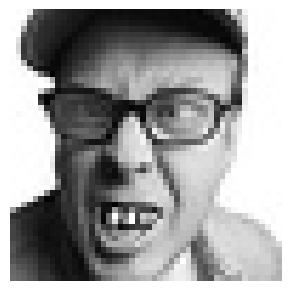

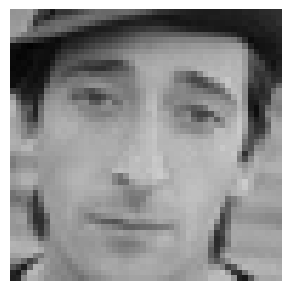

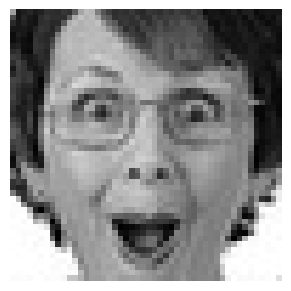

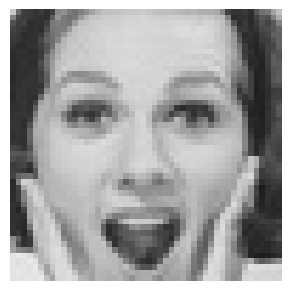

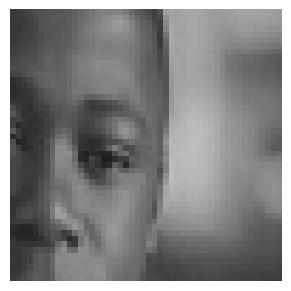

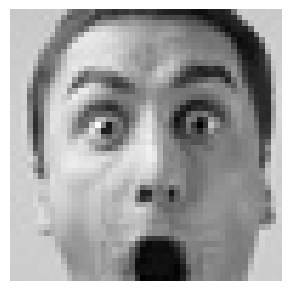

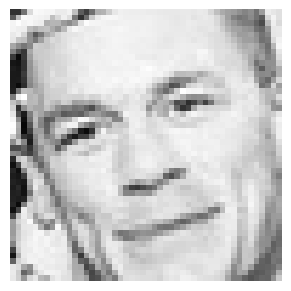

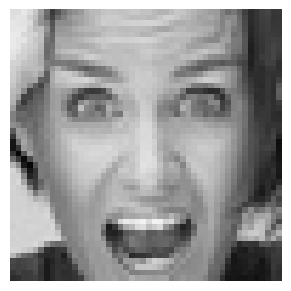

In [3]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size =48
batch_size= 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/" ,
                                                   target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size =batch_size,
                                                    class_mode = "categorical" ,
                                                    shuffle =True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)
                                                    

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# Load VGG16 with pre-trained weights
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(48, 48, 3))

model = models.Sequential()
model.add(layers.Lambda(lambda image: tf.image.resize(image, (48, 48)), input_shape=(None, None, 3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

# Freeze the convolutional base
conv_base.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        "train/",
        target_size=(48, 48),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        "test/",
        target_size=(48, 48),
        batch_size=20,
        class_mode='categorical')

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=[ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 48, 48, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14980935 (57.15 MB)
Trainable params: 14980935 (57.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Found 28709 im

In [6]:
model_json = model.to_json()
with open("model_a1.json","w") as json_file:
    json_file.write(model_json)